In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, cdist

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
df = pd.read_excel('/content/drive/MyDrive/CsvFiles/Credit_Card_Customer_Data.xlsx')

In [44]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [45]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 660 rows and 7 columns.


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


**Check for Missing Values**

In [47]:
df.isna().sum()

,0
Sl_No,0
Customer Key,0
Avg_Credit_Limit,0
Total_Credit_Cards,0
Total_visits_bank,0
Total_visits_online,0
Total_calls_made,0


- No missing values in the dataset

**Check for Duplicate Values**

In [48]:
df.duplicated().sum()

np.int64(0)

- No duplicate values in the dataset

**Statistical Summary of Dataset**

In [49]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


**Observations**

- The mean average credit limit is ₹34,574 while the median credit limit is ₹18,000, indicating a right-skewed distribution with a few high-value customers. Credit limits range from ₹3,000 to ₹2,00,000.

- Customers hold an average of ~5 credit cards, with most customers owning between 3 and 6 cards.

- On average, customers visit the bank branch about 2 times per year, suggesting limited reliance on physical channels.

- The median number of online visits is 2 per year, but usage varies widely, indicating mixed levels of digital engagement.

- Customers make an average of 3-4 calls per year to customer service, highlighting a notable dependency on support services.

- Some customers have zero visits or calls, pointing to a segment that is either digitally independent or minimally engaged.

## EDA

In [50]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Univariate Analysis

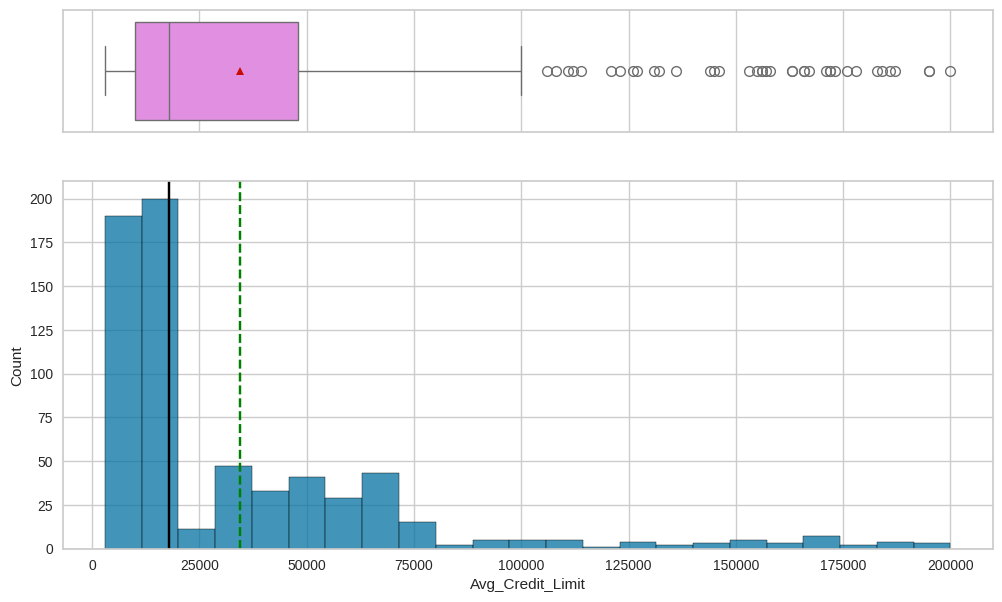

In [51]:
histogram_boxplot(df, 'Avg_Credit_Limit')

- The average credit limit distribution is heavily right-skewed, so the mean credit limit is higher than the median
- Most customers are clustered at lower credit limits and a small number of customers having very high limits, confirming the presence of high-value outliers that pull the average upward.

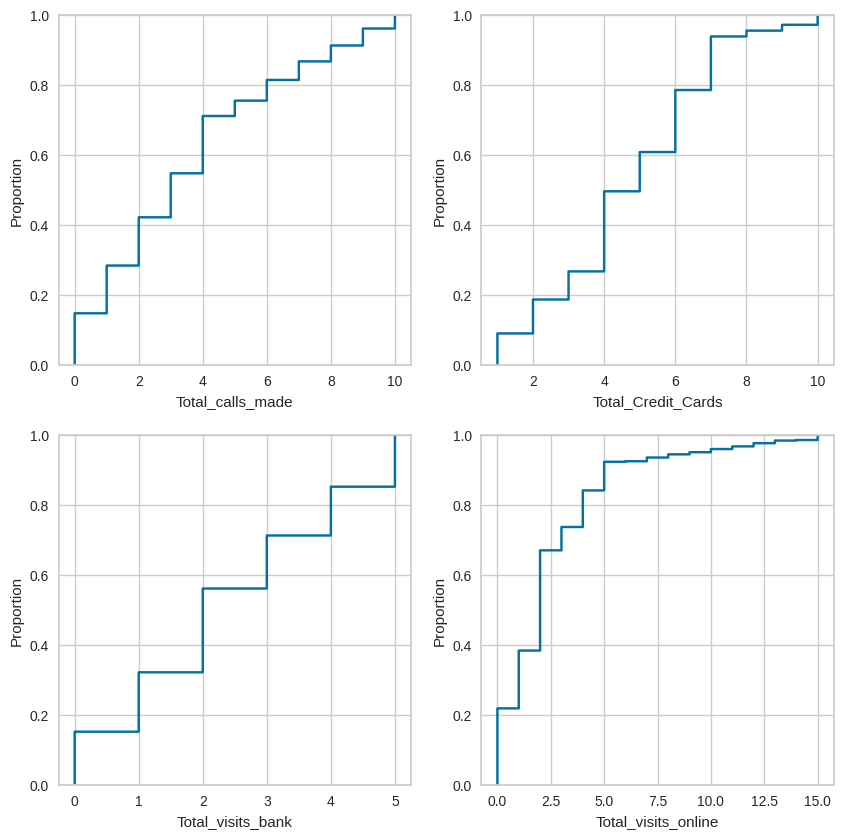

In [52]:
cols = ['Total_calls_made', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online']
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i in range(len(cols)):
  sns.ecdfplot(data=df, x=cols[i], ax=axs[i//2, i%2])

- Around 85% of customers have made 8 or fewer calls
- About 75% of customers hold 6 or fewer credit cards.
- Approximately 70% of customers visit the bank 3 times or less per year.
- Roughly 85% of customers make 5 or fewer online visits annually, with a small highly active segment.

### Bivariate Analysis

In [53]:
cols = df[['Total_calls_made', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Avg_Credit_Limit']]

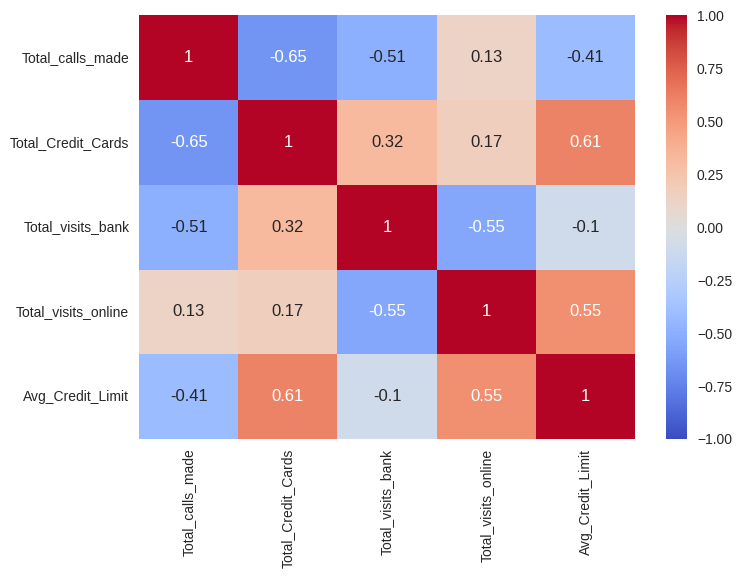

In [54]:
sns.heatmap(cols.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1);

- Total credit cards and Avg Credit Limit show a strong positive correlation (0.61), indicating that customers owning more credit cards tend to have higher average credit limits.

- Total online visits and Avg Credit Limit are positively correlated (0.55), suggesting that high-value customers prefer digital channels over physical branch visits or call-based support.

- Online visits and bank visits exhibit a moderate negative correlation (-0.55), indicating that customers generally prefer one primary mode of interaction rather than using multiple channels.

- Total calls made is negatively correlated with both Avg Credit Limit (-0.41) and Total Credit Cards (-0.65), implying that lower-value customers rely more on call-based support.

## Data Preprocessing

- Dropping columns `Avg_Credit_Limit` and `Sl_No` as they can't be useful for clustering the customers into different segments

In [55]:
df.drop(['Sl_No', 'Customer Key'], axis=1, inplace=True)

- Scaling the remaining columns

In [56]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [57]:
df_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


In [58]:
# creating dataframe copies for K-Means and Hierarchial Clustering
km_df = df.copy()
hc_df = df.copy()

## Model Building

### KMeans Clustering

Number of Clusters:  2 	Average Distortion:  1.7178787250175898
Number of Clusters:  3 	Average Distortion:  1.1466276549150365
Number of Clusters:  4 	Average Distortion:  1.0902973540817666
Number of Clusters:  5 	Average Distortion:  0.9906853650098948
Number of Clusters:  6 	Average Distortion:  0.9515009282361341
Number of Clusters:  7 	Average Distortion:  0.9094119827472316
Number of Clusters:  8 	Average Distortion:  0.9191292344244387
Number of Clusters:  9 	Average Distortion:  0.8990131857179275
Number of Clusters:  10 	Average Distortion:  0.8723089051392604


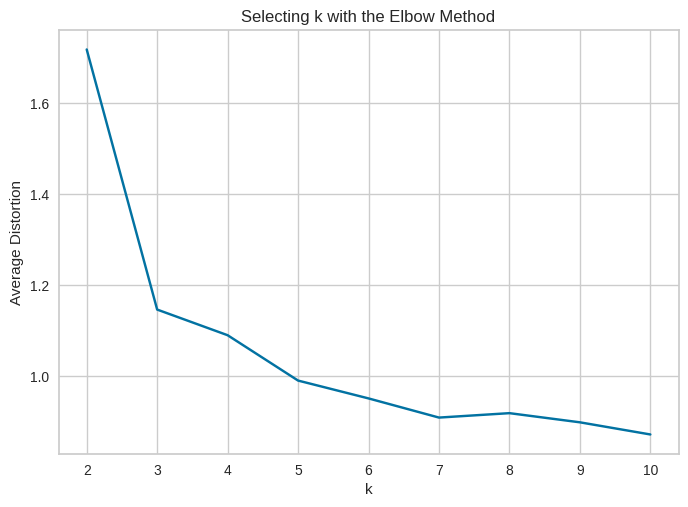

In [59]:
clusters = range(2, 11)
meanDistortions = []

for k in clusters:
  kmeans = KMeans(n_clusters=k, random_state=1)
  kmeans.fit(df_scaled)
  distortion = sum(np.min(cdist(df_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1))/df_scaled.shape[0]
  meanDistortions.append(distortion)
  print('Number of Clusters: ', k, '\tAverage Distortion: ', distortion)

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

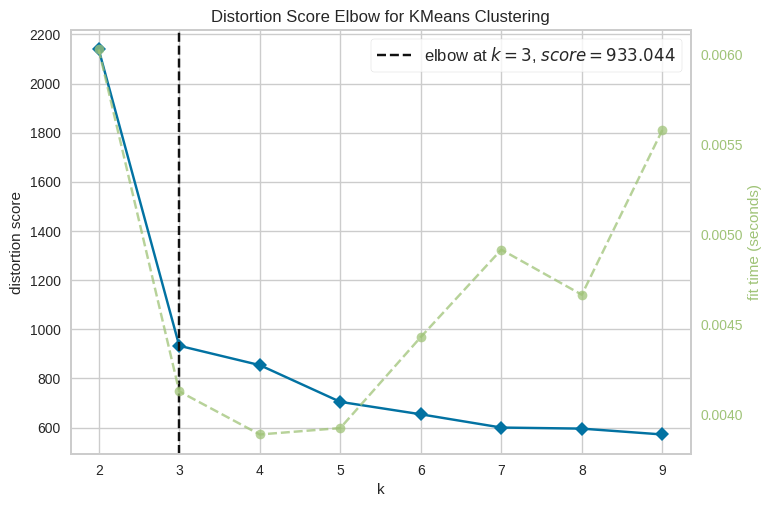

KMeans(n_clusters=9, random_state=1)

In [60]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 10), timings=True, locate_elbow=True)
visualizer.fit(df_scaled)
visualizer.show()
model.fit(df_scaled)

In [61]:
silh_score = []
clusters = range(2, 11)
for k in clusters:
  kmeans = KMeans(n_clusters=k, random_state=1)
  kmeans.fit(df_scaled)
  labels = kmeans.labels_
  sil_avg = silhouette_score(df_scaled, labels)
  silh_score.append(sil_avg)
  print('Number of Clusters: ', k, '\tSilhouette Score: ', sil_avg)

Number of Clusters:  2 	Silhouette Score:  0.5703183487340514
Number of Clusters:  3 	Silhouette Score:  0.5157182558881063
Number of Clusters:  4 	Silhouette Score:  0.3744071798973986
Number of Clusters:  5 	Silhouette Score:  0.27167502160723267
Number of Clusters:  6 	Silhouette Score:  0.24804756291576194
Number of Clusters:  7 	Silhouette Score:  0.24791254258020035
Number of Clusters:  8 	Silhouette Score:  0.22570382558070443
Number of Clusters:  9 	Silhouette Score:  0.19931783829027247
Number of Clusters:  10 	Silhouette Score:  0.20939001908412339


- From sihouette score and KElbowVisualizer, k = 3 seems to be optimal number of clusters

**Silhouette Plot**

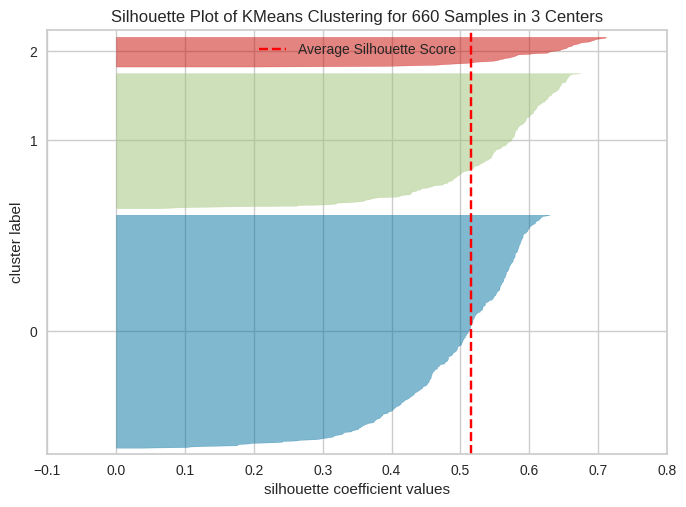

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [62]:
model = KMeans(n_clusters=3, random_state=1)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_scaled)
visualizer.show()

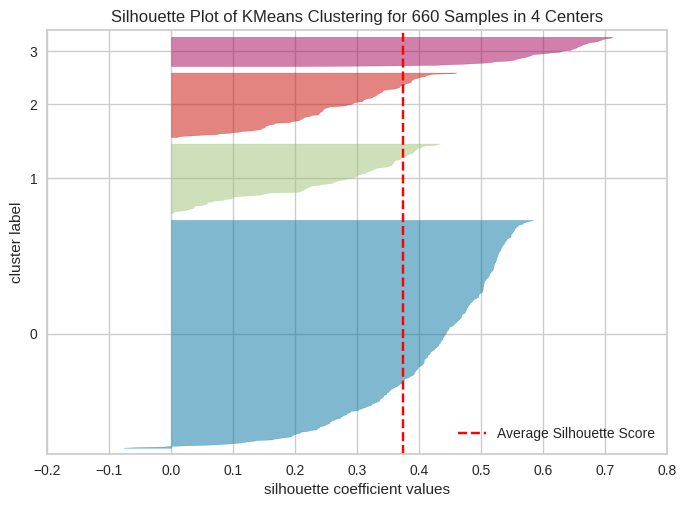

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [63]:
model = KMeans(n_clusters=4, random_state=1)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_scaled)
visualizer.show()

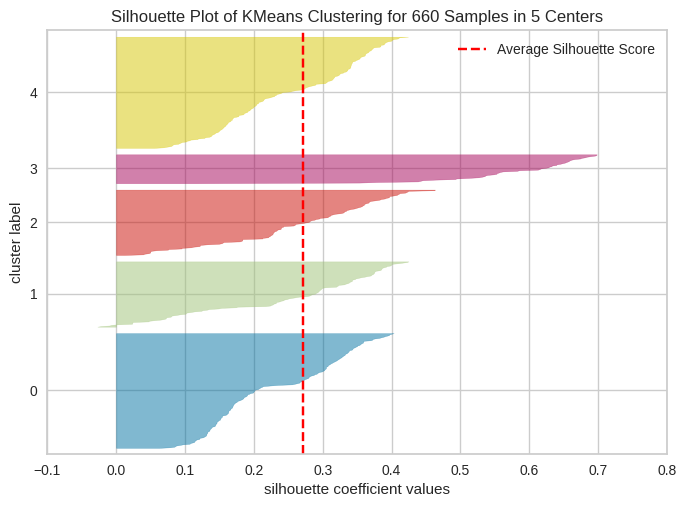

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [64]:
model = KMeans(n_clusters=5, random_state=1)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_scaled)
visualizer.show()

- Optimal number of Clusters k = 3

**Final KMeans Model**

In [65]:
model = KMeans(n_clusters=3, random_state=1)
model.fit(df_scaled)
km_df['km_cluster'] = model.labels_

**Cluster Profiling**

In [66]:
grouped_km_df = km_df.groupby('km_cluster').mean()
grouped_km_df['count'] = km_df.groupby('km_cluster')['Total_calls_made'].count()
grouped_km_df['count'] = grouped_km_df['count'].astype(int)
grouped_km_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count
km_cluster,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [67]:
grouped_km_df.style.highlight_max(color='blue',axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count
km_cluster,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


**Cluster 0 :**

- Loyal, high-card customers with moderate credit limits who prefer branch-based interactions and respond well to relationship-led upgrades and loyalty rewards.

- Best targeted with no-fee premium upgrades, offline cashback partnerships, and milestone-based loyalty benefits.

**Cluster 1 :**

- Low credit limit, digitally active customers with high service dependency, indicating need for simpler products and better support.

- Ideal for no-fee entry cards, cashback-heavy online offers, EMI options

**Cluster 2 :**

- Small but highly valuable segment with very high credit limits, heavy online usage, and minimal service needs.

- Should be targeted with premium cards, customizable perks, exclusive travel/lifestyle rewards.

### Hierarchial Clustering

**Computing Cophenetic Correlation**

In [68]:
distance_metrics = ['euclidean', 'cityblock', 'mahalanobis', 'chebyshev']
linkage_metrics = ['single', 'complete', 'average', 'weighted']

high_coph_corr = 0
high_dm = ''
high_lm = ''

for dm in distance_metrics:
  for lm in linkage_metrics:
    Z = linkage(df_scaled, metric=dm, method=lm)
    c, coph_dists = cophenet(Z, pdist(df_scaled))
    print(f'Distance Metric: {dm}, Linkage Metric: {lm}, Cophenetic Correlation: {c}')

    if c > high_coph_corr:
      high_coph_corr = c
      high_dm = dm
      high_lm = lm

Distance Metric: euclidean, Linkage Metric: single, Cophenetic Correlation: 0.7391220243806552
Distance Metric: euclidean, Linkage Metric: complete, Cophenetic Correlation: 0.8599730607972423
Distance Metric: euclidean, Linkage Metric: average, Cophenetic Correlation: 0.8977080867389372
Distance Metric: euclidean, Linkage Metric: weighted, Cophenetic Correlation: 0.8861746814895477
Distance Metric: cityblock, Linkage Metric: single, Cophenetic Correlation: 0.7252379350252723
Distance Metric: cityblock, Linkage Metric: complete, Cophenetic Correlation: 0.8731477899179829
Distance Metric: cityblock, Linkage Metric: average, Cophenetic Correlation: 0.896329431104133
Distance Metric: cityblock, Linkage Metric: weighted, Cophenetic Correlation: 0.8825520731498188
Distance Metric: mahalanobis, Linkage Metric: single, Cophenetic Correlation: 0.7058064784553605
Distance Metric: mahalanobis, Linkage Metric: complete, Cophenetic Correlation: 0.6663534463875359
Distance Metric: mahalanobis, Linka

In [69]:
print(f'The highest cophenetic correlation is {high_coph_corr} with distance metric {high_dm} and linkage metric {high_lm}')

The highest cophenetic correlation is 0.8977080867389372 with distance metric euclidean and linkage metric average


**Checking the Ward Linkage**

In [70]:
Z = linkage(df_scaled, metric='euclidean', method='ward')
c, coph_dists = cophenet(Z, pdist(df_scaled))
print(f'Distance Metric: Euclidean, Linkage Metric: Ward, Cophenetic Correlation: {c}')

Distance Metric: Euclidean, Linkage Metric: Ward, Cophenetic Correlation: 0.7415156284827493


- The `Ward` linkage method has lower cophenetic correlation.

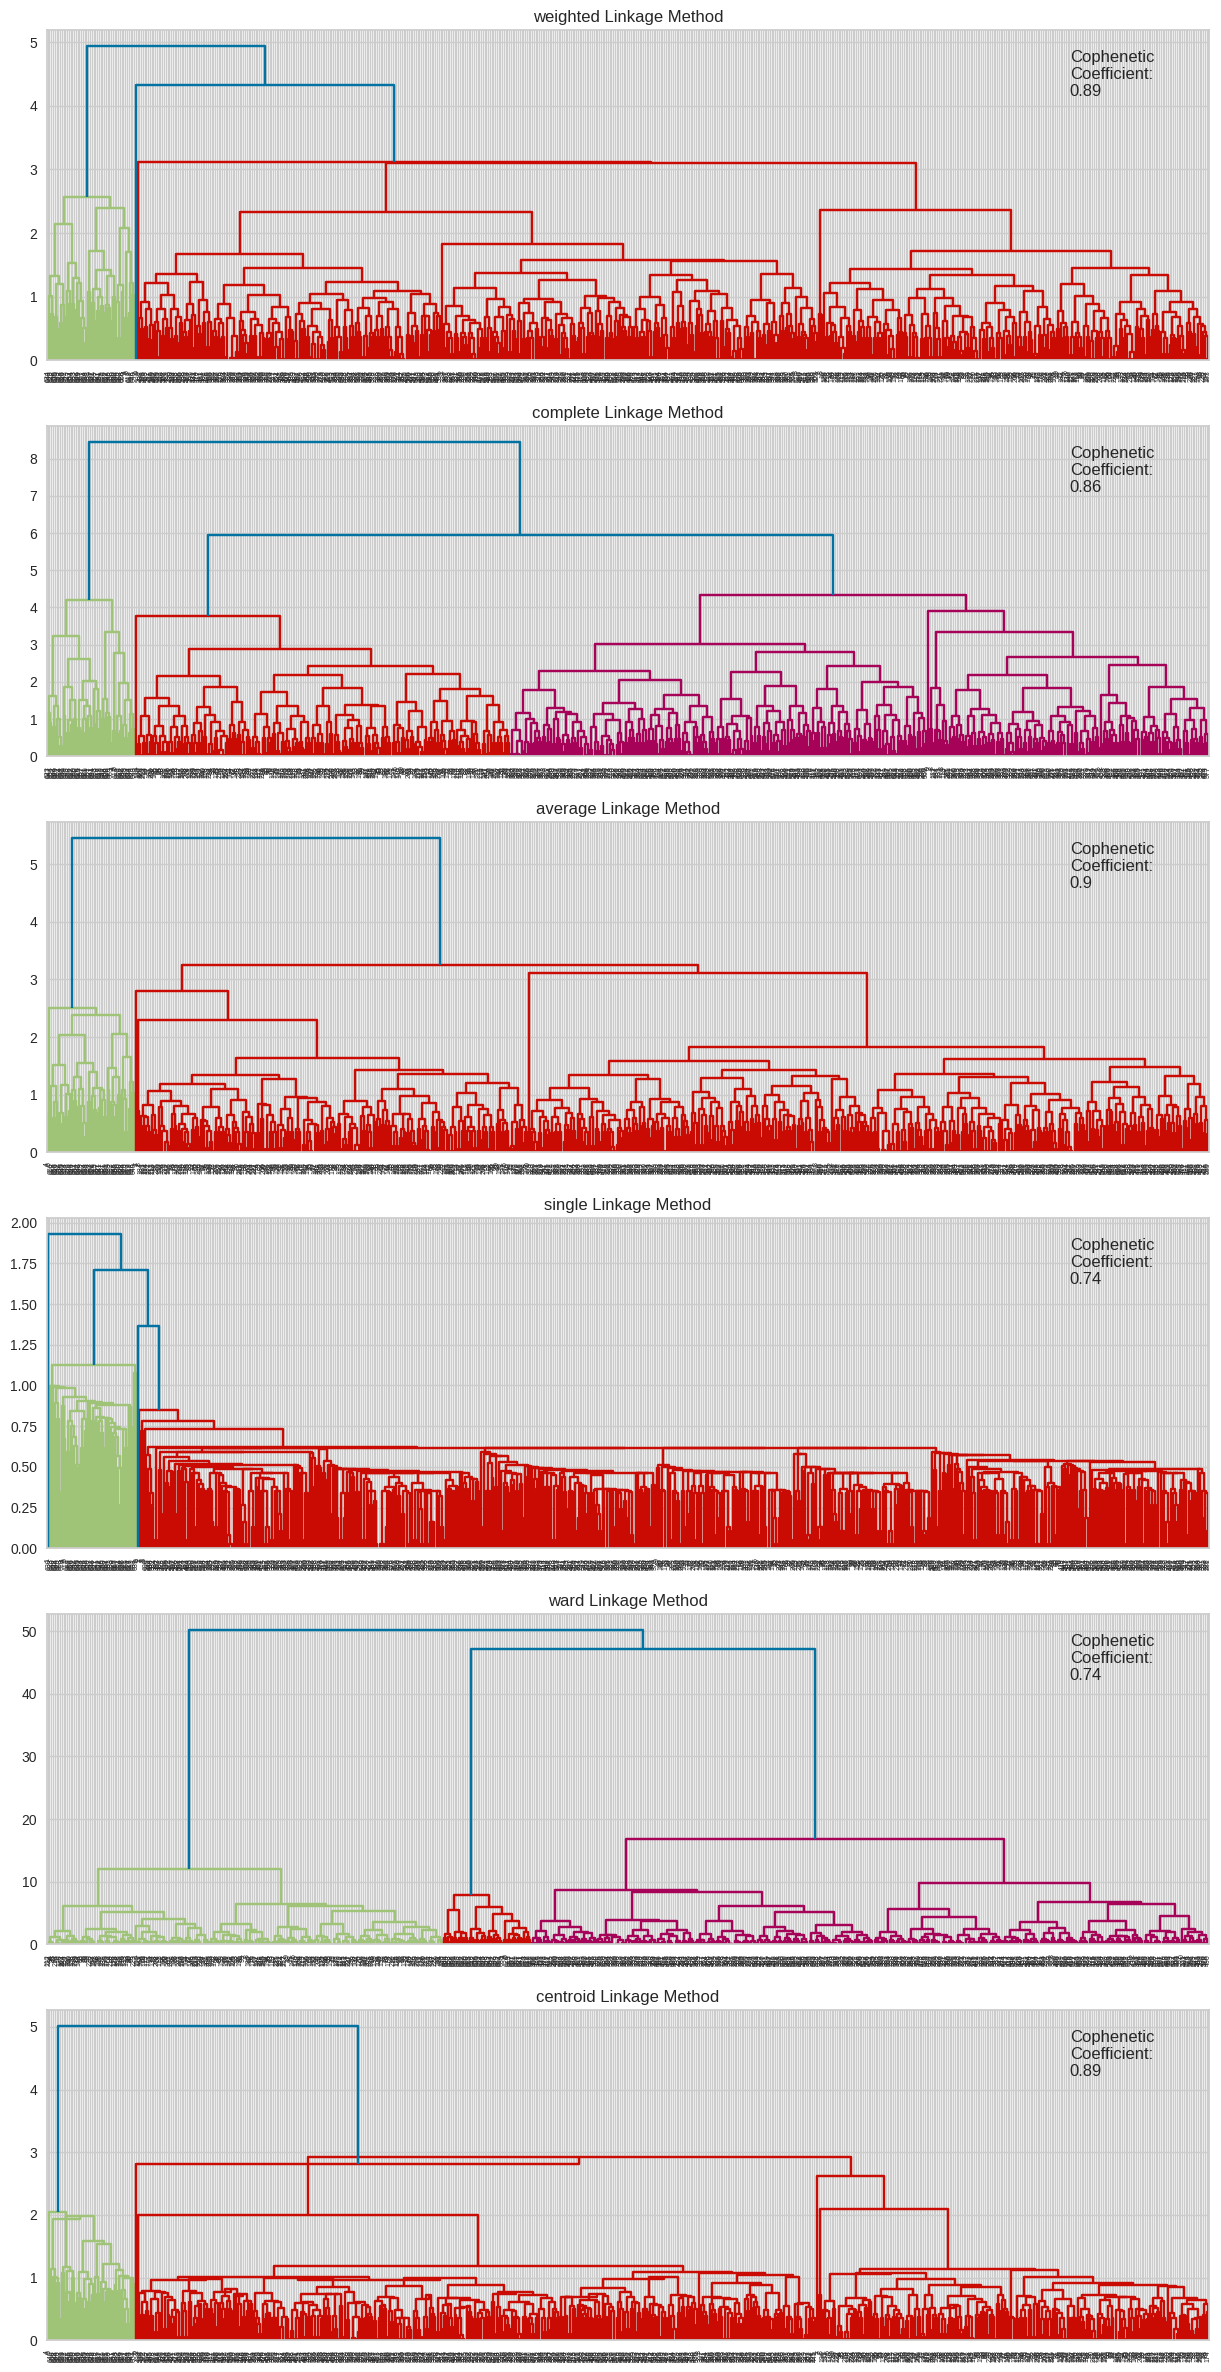

In [71]:
linkage_methods = ['weighted', 'complete', 'average', 'single', 'ward', 'centroid']
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

for i, lm in enumerate(linkage_methods):
  Z = linkage(df_scaled, method=lm, metric='euclidean')
  c, coph_dists = cophenet(Z, pdist(df_scaled))

  dendrogram(Z, ax=axs[i])
  axs[i].set_title(f'{lm} Linkage Method')
  axs[i].annotate(f'Cophenetic\nCoefficient:\n{round(c, 2)}', (0.88, 0.8), xycoords='axes fraction')
  compare.append([lm, c])

compare = pd.DataFrame(compare, columns=compare_cols)

**Observations**

- Looking the the above dendrograms, the Ward linkage seems to result in the best separation between clusters, even though its cophenetic correlation is lower than the other linkages.
- 4 looks to be a good choice for no. of clusters.

**Final Hierarchial Clustering**

In [72]:
model = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
model.fit(df_scaled)
hc_df['hc_cluster'] = model.labels_

**Cluster Profiling**

In [73]:
grouped_hc_df = hc_df.groupby('hc_cluster').mean()
grouped_hc_df['count'] = hc_df.groupby('hc_cluster')['Total_calls_made'].count()
grouped_hc_df['count'] = grouped_hc_df['count'].astype(int)
grouped_hc_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count
hc_cluster,,,,,,
0,12151.111111,2.422222,0.937778,3.546667,6.857778,225
1,38298.429319,5.670157,2.523560,0.947644,2.099476,191
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,29474.226804,5.365979,4.448454,1.010309,1.891753,194


In [74]:
grouped_hc_df.style.highlight_max(color='blue',axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count
hc_cluster,,,,,,
0,12151.111111,2.422222,0.937778,3.546667,6.857778,225
1,38298.429319,5.670157,2.523560,0.947644,2.099476,191
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,29474.226804,5.365979,4.448454,1.010309,1.891753,194


**Cluster 0 :**

- Low credit limit and fewer cards, but high online usage and the highest service calls, indicating digital adoption with frequent issues.

- Best targeted with simple no-fee cards, strong cashback offers, and improved digital support to reduce call dependency.

**Cluster 1 :**
- Moderate high credit limits with multiple cards and mixed bank + online interactions, showing stable, long-term engagement.

- Suitable for card upgrades, loyalty-based rewards, and personalized cross-sell campaigns.

**Cluster 2 :**
- Very high credit limit and card ownership with extreme online usage and minimal service needs.

- Ideal for premium cards, exclusive perks, milestone rewards, and referral-led growth.

**Cluster 3 :**
- Moderate credit limit with multiple cards but highest branch visits and low digital usage.

- Should be engaged through relationship-led offers, assisted digital onboarding, and offline partner benefits.

## Comparing Clusters Obtained from K-means and Hierarchical clustering techniques

- Premium customers are consistently identified by both methods - high confidence in targeting this segment.Only 7\% of the customers have been classified as premium customers in both clustering techniques.

- Customers with low credit limit, high online visits and highest service calls are also commonly identified by both clustering techniques.In both techniques, ~34\% of customers have been categorized into this faction.

- Both techniques identify customers with moderate credit limit.However, Hierarchial clustering splits mid-value customers into:
  1. *Branch-dependent customers* - customers who prefer branch visits over other support mediums
  2. *Balanced, multi-channel customers* - customers who tend to use all available support channels.Instead of relying on just branch visits, they also use digital platforms or calls

## Actionable Insights & Recommendation

1.**Target premium customers with exclusive offerings** : Customers with very high credit limits and strong digital usage should be offered premium cards, customizable perks, milestone-based rewards, and referral incentives to maximize revenue with low service cost.

2.**Fix digital experience for support-heavy users** : Digitally active customers making frequent service calls indicate usability gaps; introduce guided onboarding, improved in-app self-service, AI chatbots, and clearer communication to reduce operational load.

3.**Use no-fee and cashback-led products to drive acquisition** : Low-credit and early-stage customers should be targeted with no-fee cards, instant approvals, online cashback offers, and easy EMI options to increase penetration and card usage.

4.**Retain branch-oriented customers while nudging digital adoption** : Relationship-driven customers should receive loyalty rewards and branch-assisted digital onboarding, ensuring retention while gradually shifting them to lower-cost digital channels.

5.**Apply personalized card recommendations to boost cross-sell** : Introduce a credit card suggester using customer behavior to recommend suitable cards, improving engagement and long-term loyalty.

6.**Align service priority with customer value** : Provide priority support for premium segments and proactive issue resolution for high-call clusters to improve satisfaction and reduce churn risk.
